# 01. Load packages

In [1]:
import torch 
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
device = torch.device('cuda:0')

# 02. Load datasets

In [2]:
from torchvision.datasets import mnist, CIFAR10
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)
    

# load_datasets    
# load_datasets = CIFAR10(root='./data', download=True, transform=None)
# X = load_datasets.train_data.transpose((0,2,3,1))
# Y = np.array(load_datasets.train_labels)

load_datasets = mnist.MNIST(root = './data', download=True)
X = load_datasets.train_data.unsqueeze(-1)
Y = load_datasets.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
X.shape

torch.Size([60000, 28, 28, 1])

In [4]:
DS = CustomDataset(X,Y)
DL = DataLoader(DS,128, True)

# 03. CNN kernel

![CNN example](https://miro.medium.com/proxy/0*9J3MK1gd2zrFDzDN.gif)  


1. Image2Patch

$$ B \times W \times H \times C \rightarrow B \times W_{kernel} \times H_{kernel} \times C \times \#\ \mathrm{of\ kernel\ window }$$

2. Kernel $\cdot$ Patch

To compute the next convolution node, we should repeat the loop by # of output channel

$$ \mathrm{Weight}_{kernel} \in \mathbb{R}^{1 \times W_{kernel} \times H_{kernel} \times C_{input} \times C_{output}} $$

$$\mathrm{Patches} \in \mathbb{R}^{B \times W_{kernel} \times H_{kernel} \times C \times \#\ \mathrm{of\ kernel\ window }}  $$

for n in range($C_{output}$):

-> next value = $\mathrm{Weight}_{kernel}$[n] $\cdot$ $\mathrm{Patches}$

In [5]:
from torch.nn import Module
from torch import nn
from itertools import product
from torch.nn import functional as F

class cnn_module(Module):
    def __init__(
        self, 
        input_channel,
        output_channel,
        kernel_size
    ):
        super().__init__()
        
        self.output_channel = output_channel
        self.kernel_size = (kernel_size, kernel_size)
        
        self.weight = nn.Parameter(
            torch.randn((output_channel, *self.kernel_size, input_channel))
        )
        
        self.bias = nn.Parameter(
            torch.randn((output_channel))
        )
        
        self.pad_size = kernel_size // 2
        
        self.n_samples = None
        self.width = None
        self.height = None

        
    # pad image
    def _add_pad(self, img):
        n_samples, width, height, channel = img.shape
        self.n_samples, self.width, self.height = n_samples, width, height
        zeros = torch.zeros(
            (n_samples, width + 2 * self.pad_size, height + 2 * self.pad_size, channel)
        ).to(img.device)
        zeros[:, self.pad_size:self.pad_size+width, self.pad_size:self.pad_size+height] += img
        return zeros
    
    # sliced image
    def _slicing(self, img):
        n_samples, width, height, channel = img.shape
        
        # product는 뒤에 있는게 먼저 작동함
        stack = [
            img[
                :,
                w:w+self.kernel_size[0],
                h:h+self.kernel_size[1],
                :
            ] for w,h in product(
                range(width - self.kernel_size[0] + 1), 
                range(height - self.kernel_size[1] + 1)
            )
        ]
#         for w,h in product(range(width - self.kernel_size[0] + 1), range(height - self.kernel_size[1] + 1)):
#             stack.append()
        return torch.stack(stack,-1)
    
    
    # weight product
    def _weight_product(self, features):
        stack = []
        for n in range(self.output_channel):
            w = self.weight[n].unsqueeze(0).unsqueeze(-1)
            stack.append( w * features )

        return torch.stack(stack,-1).sum([1,2,3]).reshape(self.n_samples, self.width, self.height, self.output_channel) + self.bias
    
    
    def forward(self, img):
        pad_img = self._add_pad(img)
        sliced_img = self._slicing(pad_img)
        feature = self._weight_product(sliced_img)
        return feature

In [6]:
class CNN(Module):
    def __init__(self, channel_lists, kernel_size, n_class = 10):
        super().__init__()
        
        self.channel_lists = channel_lists
        
        self.cnn_layers = nn.ModuleList(
            [
                cnn_module(i,o, kernel_size) for i,o in zip(channel_lists, channel_lists[1:])
            ]
        )
        
        self.batch_layers = nn.ModuleList(
            [
                nn.BatchNorm2d(o) for o in channel_lists[1:]
            ]
        )
        
        self.output_layers = nn.Linear(channel_lists[-1], n_class)
        self.a = nn.ReLU()
        self.d = nn.Dropout(.3)
    
    def forward(self, img):
        x = img
        for l,b in zip(self.cnn_layers, self.batch_layers):
            x = l(x).permute([0,3,1,2])
            x = b(x).permute([0,2,3,1])
            x = self.a(x)
            x = self.d(x)
        
        x = x.view(img.size(0), -1, self.channel_lists[-1]).max(1).values
        return self.output_layers(x)
    
    
    def layer_maps(self, img):
        maps = []
        x = img
        for l,b in zip(self.cnn_layers, self.batch_layers):
            x = l(x).permute([0,3,1,2])
            maps.append(x)
            x = b(x).permute([0,2,3,1])
            x = self.a(x)
            x = self.d(x)
        return maps
        
#         x = x.view(img.size(0), -1, self.channel_lists[-1]).max(1).values
#         return self.output_layers(x)

In [7]:
from tqdm import tqdm

In [8]:
cnn_model = CNN(
    [1, 8, 16, 32], 3
)
cnn_model.to(device)

optimizer = torch.optim.Adam(cnn_model.parameters())

In [9]:
def training_batch(epoch):
    TQ = tqdm(DL)

    losses = []
    acces = []

    for n,(x,y) in enumerate(TQ, 1):    

        x = x.to(device)
        y = y.to(device).long()

        logits = cnn_model(x)
        loss = F.cross_entropy(logits, y)   
        acc = (logits.max(1).indices == y.to(device)).detach().cpu().numpy().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        acces.append(acc)

        TQ.set_postfix_str(f'Loss: {sum(losses) / n:.5} ACC: {sum(acces) / n * 100:.5}%')
        TQ.set_description_str(f'Epoch: {epoch}')
    return losses, acces


def training_epochs(max_epochs):
    losses = []
    acces = []
    for e in range(max_epochs):
        l,a = training_batch(e+1)
        losses.append(l); acces.append(a)
        
    return losses, acces


logger = training_epochs(10)

Epoch: 10: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s, Loss: 0.98638 ACC: 66.106%]


In [10]:
torch.save(cnn_model.state_dict(), 'Prac 03. cnn_model_.ckpt')

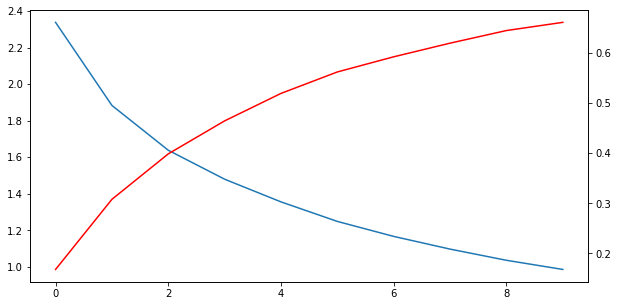

In [11]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot([sum(i)/len(i) for i in logger[0]])
tax = ax.twinx()
tax.plot([sum(i)/len(i) for i in logger[1]],'r')

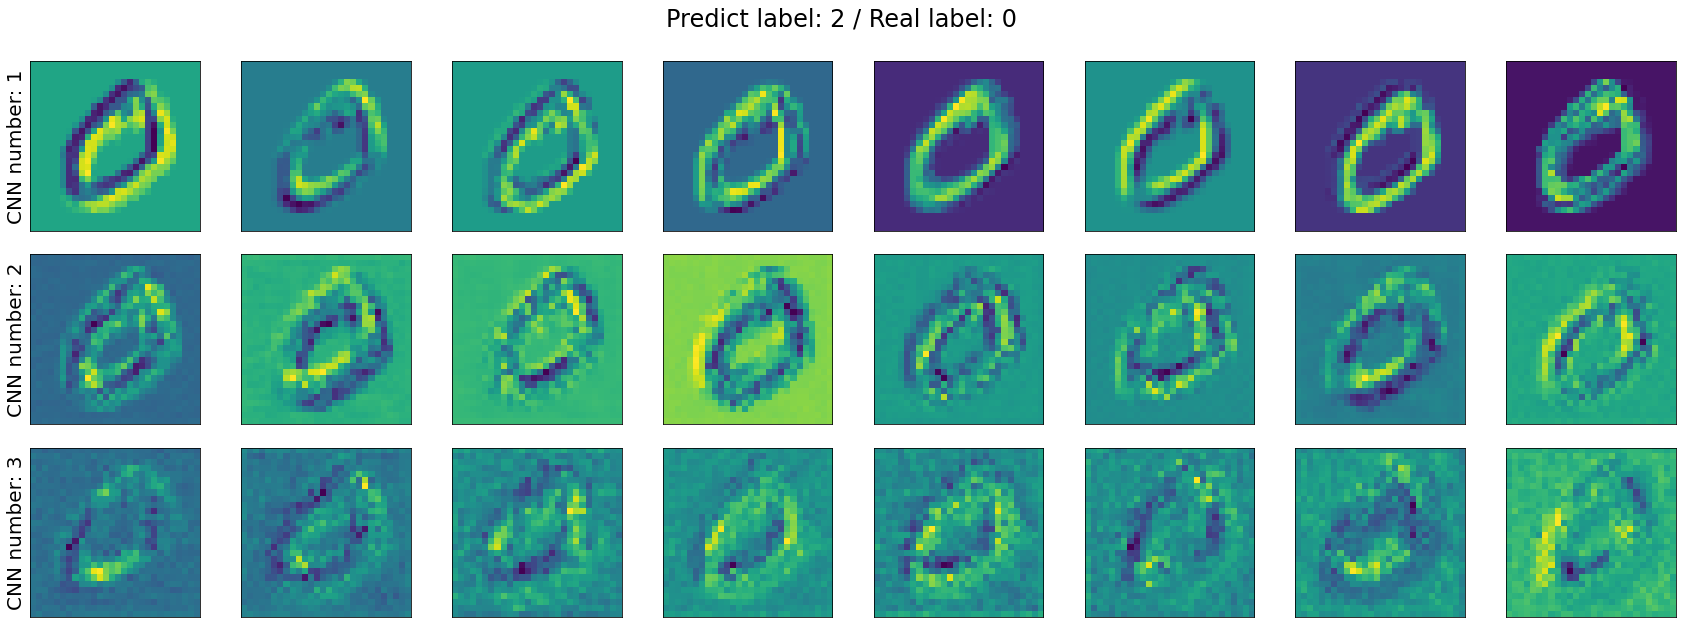

In [12]:
import random

sample_number = 1

with torch.no_grad():
    sample_x, sample_y = DS.__getitem__(sample_number)
    sample_x = sample_x.to(device).unsqueeze(0) ; sample_y = sample_y.to(device).unsqueeze(0)
    
    logits = cnn_model(sample_x)
    features = cnn_model.layer_maps(sample_x)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 8, figsize = (8 * 3, 3 * 3))

for n in range(3):
    f = features[n][0]
    full_length = f.size(0)
    rand_idx = list(range(full_length))
    random.shuffle(rand_idx)
    rand_idx = rand_idx[:8]

    for m,i in enumerate(rand_idx):
        ax[n][m].imshow(f[i].cpu().numpy())
        ax[n][m].set_xticks([])
        ax[n][m].set_yticks([])
        
        if m == 0:
            ax[n][m].set_ylabel(f'CNN number: {n + 1}')
    
fig.suptitle('Predict label: {} / Real label: {}'.format(logits.max(1).indices.item(), sample_y.item()))
fig.tight_layout()
fig.show()
#     print(full_length, rand_idx)
    
    